# 딥러닝 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [3]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [4]:
df = fdr.DataReader('036570','2020-01-01', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [5]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,542000,545000,539000,541000,40246,0.000000
2020-01-03,547000,568000,542000,565000,112404,0.044362
2020-01-06,562000,587000,562000,579000,107006,0.024779
2020-01-07,583000,596000,574000,594000,84378,0.025907
2020-01-08,587000,604000,584000,604000,109267,0.016835
...,...,...,...,...,...,...
2022-04-06,475000,483500,469000,474000,96750,-0.012500
2022-04-07,469000,471500,462000,462000,103079,-0.025316
2022-04-08,462500,466500,453500,458000,87055,-0.008658


In [6]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

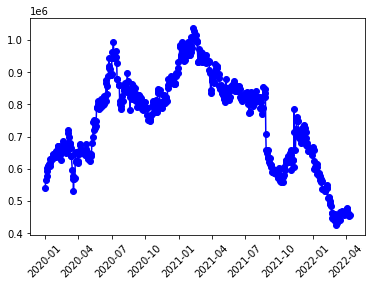

In [7]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [8]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"NCSoft_N\",\"keywords\":[\"NCSoft\",\"환불\",\"사건\"]}, {\"groupName\":\"NCSoft_P\",\"keywords\":[\"리니지\",\"업데이트\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [9]:
search_count_json = json.loads(search_count)

In [10]:
search_count_json

{'endDate': '2022-04-12',
 'results': [{'data': [{'period': '2020-01-01', 'ratio': 2.10831},
    {'period': '2020-01-02', 'ratio': 3.18808},
    {'period': '2020-01-03', 'ratio': 3.20088},
    {'period': '2020-01-04', 'ratio': 2.22354},
    {'period': '2020-01-05', 'ratio': 2.38999},
    {'period': '2020-01-06', 'ratio': 3.59352},
    {'period': '2020-01-07', 'ratio': 3.55511},
    {'period': '2020-01-08', 'ratio': 3.90508},
    {'period': '2020-01-09', 'ratio': 3.79411},
    {'period': '2020-01-10', 'ratio': 3.84106},
    {'period': '2020-01-11', 'ratio': 2.32171},
    {'period': '2020-01-12', 'ratio': 2.39426},
    {'period': '2020-01-13', 'ratio': 3.80692},
    {'period': '2020-01-14', 'ratio': 3.71302},
    {'period': '2020-01-15', 'ratio': 4.06299},
    {'period': '2020-01-16', 'ratio': 3.46549},
    {'period': '2020-01-17', 'ratio': 3.29904},
    {'period': '2020-01-18', 'ratio': 2.29183},
    {'period': '2020-01-19', 'ratio': 2.24488},
    {'period': '2020-01-20', 'ratio': 3.337

## 1-3. 데이터 전처리 및 Merge하기

In [11]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [12]:
df_all = df

In [13]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.07053067344563524

In [14]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

-0.3216858919029978

In [15]:
#df_all[df_all["Count"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

In [16]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
dtype: bool

In [17]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1
0,2020-01-02,542000,545000,539000,541000,40246,0.000000,3.18808,41.62007
1,2020-01-03,547000,568000,542000,565000,112404,0.044362,3.20088,30.74559
2,2020-01-06,562000,587000,562000,579000,107006,0.024779,3.59352,30.28893
3,2020-01-07,583000,596000,574000,594000,84378,0.025907,3.55511,32.89232
4,2020-01-08,587000,604000,584000,604000,109267,0.016835,3.90508,51.45320
...,...,...,...,...,...,...,...,...,...
558,2022-04-06,475000,483500,469000,474000,96750,-0.012500,3.46976,16.67875
559,2022-04-07,469000,471500,462000,462000,103079,-0.025316,3.69595,13.18765
560,2022-04-08,462500,466500,453500,458000,87055,-0.008658,3.39720,12.20178
561,2022-04-11,450500,459000,449000,453500,59322,-0.009825,3.57645,11.35674


## 1-4. Feature Selection

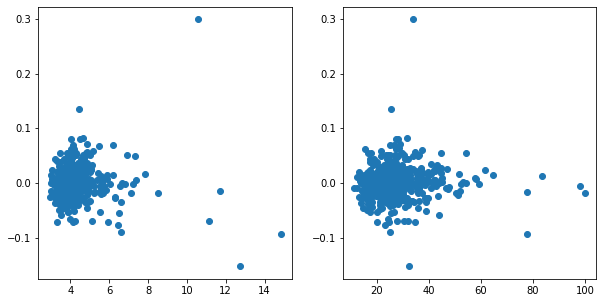

In [18]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Key_Count1"], df_all["Change"])


# 2. Define Model

In [19]:
input_size = 2 # x0의 dimension = feature의 개수 = 2
hidden_size = 10 # 임의로 지정
rnn = torch.nn.RNN(2, 10) # rnn = torch.nn.RNN(input_size, hidden_size)
input = torch.randn(1, 5, 2) # (batchsize, seq, input_size)
output, _ = rnn(input) # output (b, s, hidden_size)

In [57]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layer=1):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers = num_layer ,batch_first=True)
        #self.relu = torch.nn.ReLU()
        self.linear_classifier = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(0))
        #x = self.relu(x)
        x = self.linear_classifier(x[:,-1])
        return x

# 3. Define the loss function and the optimizer

In [58]:
input_dim = 2
hidden_dim = 10
sequence_size = 5
output_dim = 1
layer_size = 1

learning_rate = 0.001
model = RNNModel(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [33]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0','Scaled_Key_Count1']] = scaler.fit_transform(df[['Key_Count0','Key_Count1']])

In [35]:
df_all = df

In [36]:
'''
x_scaled = df_all[['Scaled_Key_Count0','Scaled_Key_Count1']].to_numpy()
y_scaled = df_all["Change"].to_numpy()

train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)
'''

'\nx_scaled = df_all[[\'Scaled_Key_Count0\',\'Scaled_Key_Count1\']].to_numpy()\ny_scaled = df_all["Change"].to_numpy()\n\ntrain_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)\n'

In [37]:
seq_x = []
seq_y = []

feature_list = ['Scaled_Key_Count0','Scaled_Key_Count1']
x = df_all[feature_list][1:6]
y = df_all["Change"][1:6]
print(y)

1    0.044362
2    0.024779
3    0.025907
4    0.016835
5    0.006623
Name: Change, dtype: float64


In [38]:
s_idx = 0
e_idx = len(df_all)
date_interval = 1
num_days = 4

In [39]:
for idx in range(s_idx, e_idx, date_interval):
    x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
    y = df_all.loc[idx:idx+num_days]["Change"].sum().tolist()

    seq_x.append(x) if len(x) == 5 else None
    seq_y.append(y) if len(x) == 5 else None

In [40]:
train_x, test_x, train_y, test_y = train_test_split(seq_x, seq_y, test_size=0.2)

In [41]:
train_x[0]

[[0.12149503586239888, 0.07631206253019124],
 [0.106397959768082, 0.07525276033394981],
 [0.12508969810901224, 0.1296582503847444],
 [0.11178995313800197, 0.06788637962999106],
 [0.09022282189408717, 0.06735684134360584]]

In [59]:
best_model = None
num_epoch = 500
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<BarContainer object of 500 artists>

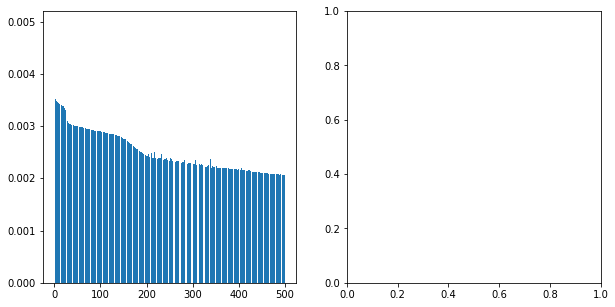

In [60]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(range(num_epoch), loss_epoch)
#ax2.scatter(train_x[-1], train_y)
#x = np.linspace(0,1,100)
#linear_weight = model.linear_classifier.weight.detach().numpy()
#lienar_bias = model.linear_classifier.bias.detach().numpy()
#y = linear_weight*x+lienar_bias
#y = y.reshape((100))
#ax2.plot(x, y, '-r', label='y='+str(linear_weight[-1][-1])+'x+'+str(lienar_bias[-1]))
#ax2.legend(loc='upper left')

In [ ]:
loss_epoch

[0.0007064181364486534,
 0.0007036996724606897,
 0.0007016302117977742,
 0.000699778444906561,
 0.0006981211099285644,
 0.0006966370450620212,
 0.0006953079311814392,
 0.0006941171570763929,
 0.0006930498199750346,
 0.0006920931015221942,
 0.0006912349788576832,
 0.0006904648576837899,
 0.0006897752927148993,
 0.000689156674636325,
 0.0006886006871282812,
 0.0006881007739038763,
 0.0006876511489127394,
 0.0006872464585093393,
 0.00068688182732771,
 0.0006865530247604054,
 0.0006862562488464232,
 0.0006859881591920242,
 0.0006857455870547272,
 0.0006855259944417195,
 0.0006853268466151944,
 0.0006851462493445506,
 0.0006849824060649199,
 0.0006848333741268761,
 0.0006846974337641627,
 0.0006845734206913207,
 0.0006844597375566093,
 0.0006843555518284629,
 0.0006842598980784582,
 0.000684171820236767,
 0.0006840904149298707,
 0.000684015170044901,
 0.0006839452228902059,
 0.0006838802508287231,
 0.0006838195795946839,
 0.0006837628208997316,
 0.000683709550094437,
 0.0006836592135628774,

# 6. Evaluation

In [63]:
x_predicted = []
for idx in range(len(test_x)):
  predicted = model(torch.tensor(test_x[idx]).float())
  x_predicted.append(predicted.detach())
x_pred_np = np.array(x_predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


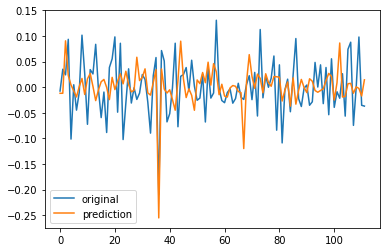

In [64]:
plt.plot(test_y)
plt.plot(x_pred_np)
plt.legend(['original', 'prediction'])
plt.show()

# 7. Prediction

In [65]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [66]:
raw_input = [[3,30], [3.9, 50], [3.3, 42], [3.1, 29], [2.9, 33]]
scaled_input = []
for a_day in raw_input:
    key_count = np.array(a_day)
    scaled = scaler.transform(key_count.reshape(1,-1)).tolist()[0]
    scaled_input.append(scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na

In [67]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [69]:
print("검색량이"+str(raw_input)+"일때 주가는", str(predicted.item()*100) )

검색량이[[3, 30], [3.9, 50], [3.3, 42], [3.1, 29], [2.9, 33]]일때 주가는 2.1821344271302223
